In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, MobileNetV2, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Veri seti yolu
data_path = 'C:/Users/Andac/Desktop/dockerAndac/meyveçürük'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
   
)
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Sanal bir test veri seti oluştur
fake_test_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  
    shuffle=False  
)

# Early stopping için callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# BayesianOptimization için model fonksiyonları
def build_xception(hp):
    xception_model = Xception(include_top=False, input_shape=(224, 224, 3))
    for layer in xception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(xception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('xception_units', min_value=32, max_value=120, step=32), activation='relu')) 
    model.add(layers.Dropout(hp.Float('xception_dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(layers.Dense(12, activation='softmax'))  

    model.compile(optimizer=Adam(learning_rate=hp.Float('xception_learning_rate', min_value=1e-8, max_value=7e-7, sampling='log')),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_mobilenetv2(hp):
    mobilenetv2_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
    for layer in mobilenetv2_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(mobilenetv2_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(units=hp.Int('mobilenetv2_units', min_value=128, max_value=256, step=32), activation='relu')) 
    model.add(layers.Dropout(hp.Float('mobilenetv2_dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(layers.Dense(12, activation='softmax'))  

    model.compile(optimizer=Adam(learning_rate=hp.Float('mobilenetv2_learning_rate', min_value=5e-7, max_value=3e-6, sampling='log')),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_inceptionv3(hp):
    inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    for layer in inception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('inception_units', min_value=60, max_value=128, step=32), activation='relu'))  
    model.add(layers.Dropout(hp.Float('inception_dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(layers.Dense(12, activation='softmax'))  

    model.compile(optimizer=Adam(learning_rate=hp.Float('inception_learning_rate', min_value=4e-8, max_value=2e-7, sampling='log')),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# BayesianOptimization için tuner'ları oluştur
xception_tuner = BayesianOptimization(build_xception, objective='val_accuracy', max_trials=5, num_initial_points=2, project_name='xception_tuner')
mobilenetv2_tuner = BayesianOptimization(build_mobilenetv2, objective='val_accuracy', max_trials=5, num_initial_points=2, project_name='mobilenetv2_tuner')
inceptionv3_tuner = BayesianOptimization(build_inceptionv3, objective='val_accuracy', max_trials=5, num_initial_points=2, project_name='inceptionv3_tuner')

# BayesianOptimization ile hiperparametre ayarı yap
xception_tuner.search(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping])
mobilenetv2_tuner.search(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping])
inceptionv3_tuner.search(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping])

# En iyi hiperparametreleri al
best_xception_params = xception_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
best_mobilenetv2_params = mobilenetv2_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
best_inceptionv3_params = inceptionv3_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


C:\Users\Andac\AppData\Local\Temp\ipykernel_2088\3207427473.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.
Reloading Tuner from .\xception_tuner\tuner0.json
Reloading Tuner from .\mobilenetv2_tuner\tuner0.json
Reloading Tuner from .\inceptionv3_tuner\tuner0.json


In [2]:

def build_inceptionv3(best_inceptionv3_params):
    inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    for layer in inception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    # best_inceptionv3_params sözlüğünden doğrudan değerleri kullan
    model.add(layers.Dense(units=best_inceptionv3_params['inception_units'], activation='relu'))
    model.add(layers.Dropout(best_inceptionv3_params['inception_dropout']))
    model.add(layers.Dense(12, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_inceptionv3_params['inception_learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_xception(best_xception_params):
    xception_model = Xception(include_top=False, input_shape=(224, 224, 3))
    for layer in xception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(xception_model)
    model.add(layers.Flatten())
    # params sözlüğünden doğrudan değerleri kullan
    model.add(layers.Dense(units=best_xception_params['xception_units'], activation='relu'))
    model.add(layers.Dropout(best_xception_params['xception_dropout']))
    model.add(layers.Dense(12, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_xception_params['xception_learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_mobilenetv2(best_mobilenetv2_params):
    mobilenetv2_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
    for layer in mobilenetv2_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(mobilenetv2_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(units=best_mobilenetv2_params['mobilenetv2_units'], activation='relu'))
    model.add(layers.Dropout(best_mobilenetv2_params['mobilenetv2_dropout']))
    model.add(layers.Dense(12, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_mobilenetv2_params['mobilenetv2_learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# En iyi hiperparametreleri al
best_inceptionv3_params = inceptionv3_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
best_xception_params = xception_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
best_mobilenetv2_params = mobilenetv2_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# En iyi hiperparametrelerle modelleri eğit
best_xception_model = build_xception(best_xception_params)
best_inceptionv3_model = build_inceptionv3(best_inceptionv3_params)
best_mobilenetv2_model = build_mobilenetv2(best_mobilenetv2_params)


inceptionv3_history = best_inceptionv3_model.fit(train_generator, validation_data=val_generator, epochs=60) 
xception_history = best_xception_model.fit(train_generator, validation_data=val_generator, epochs=60) 
mobilenetv2_history = best_mobilenetv2_model.fit(train_generator, validation_data=val_generator, epochs=60) 



Epoch 1/60
368/368 [==============================] - 73s 178ms/step - loss: 3.0643 - accuracy: 0.1108 - val_loss: 2.4851 - val_accuracy: 0.1913
Epoch 2/60
368/368 [==============================] - 62s 169ms/step - loss: 2.3694 - accuracy: 0.2187 - val_loss: 2.0301 - val_accuracy: 0.3348
Epoch 3/60
368/368 [==============================] - 62s 169ms/step - loss: 1.9798 - accuracy: 0.3517 - val_loss: 1.7160 - val_accuracy: 0.4681
Epoch 4/60
368/368 [==============================] - 62s 169ms/step - loss: 1.7035 - accuracy: 0.4583 - val_loss: 1.4783 - val_accuracy: 0.5561
Epoch 5/60
368/368 [==============================] - 62s 169ms/step - loss: 1.4861 - accuracy: 0.5310 - val_loss: 1.2932 - val_accuracy: 0.6106
Epoch 6/60
368/368 [==============================] - 62s 169ms/step - loss: 1.3101 - accuracy: 0.5972 - val_loss: 1.1462 - val_accuracy: 0.6591
Epoch 7/60
368/368 [==============================] - 62s 169ms/step - loss: 1.1735 - accuracy: 0.6372 - val_loss: 1.0273 - val_ac

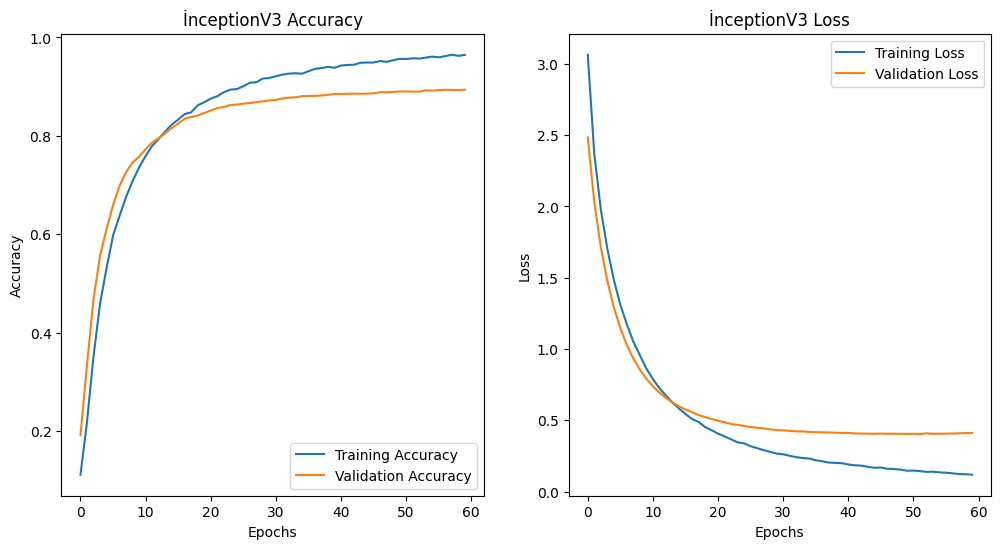

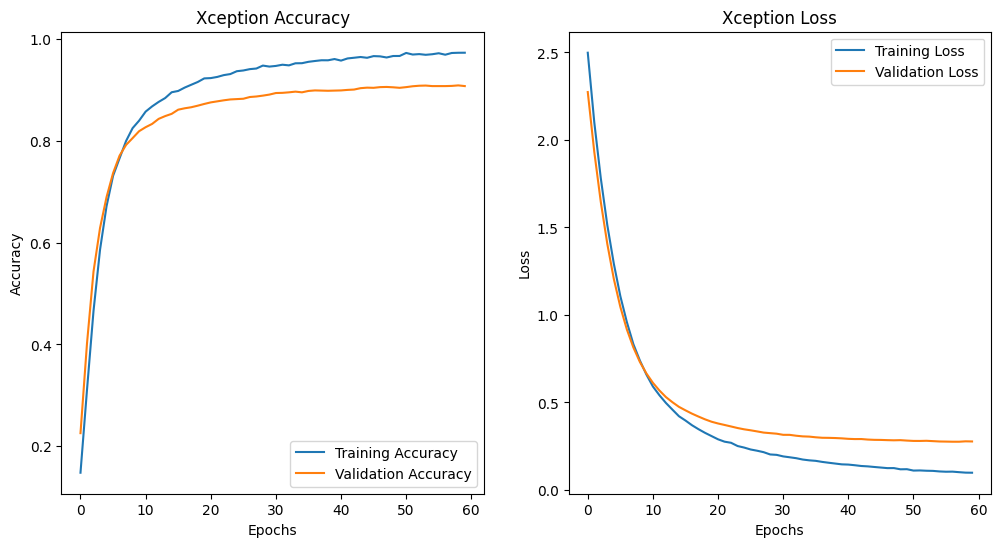

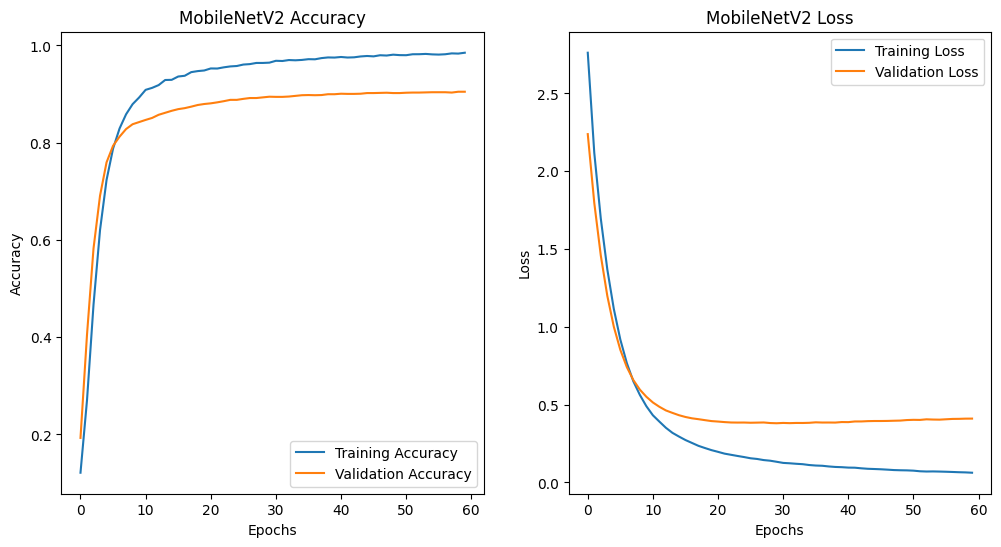

In [3]:
# Grafik çizimi
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# inceptionv3 Modelinin Eğitim Sonuçlarını Çiz
plot_history(inceptionv3_history, title='İnceptionV3')

# Xception Modelinin Eğitim Sonuçlarını Çiz
plot_history(xception_history, title='Xception')

# MobileNetV2 Modelinin Eğitim Sonuçlarını Çiz
plot_history(mobilenetv2_history, title='MobileNetV2')

In [8]:
# Test seti etiketlerini yükle
fake_test_labels = fake_test_generator.classes

# Modelleri ensemble etme
models = [best_inceptionv3_model, best_xception_model, best_mobilenetv2_model]  
weights = [0.3, 0.4, 0.3]  # Ağırlıklar

# Ensemble tahminlerini ağırlıklı olarak oluşturma
predictions_list = []
for model in models:
    predictions = model.predict(fake_test_generator, verbose=1)
    predictions_list.append(predictions)

weighted_predictions = np.zeros_like(predictions_list[0])
for predictions, weight in zip(predictions_list, weights):
    weighted_predictions += predictions * weight

ensemble_labels = np.argmax(weighted_predictions, axis=1)

# Toplam tahmin sayısına göre bir matris oluştur
ensemble_predictions = np.zeros((fake_test_generator.samples, 12))  

# Tahminleri ve ağırlıkları kullanarak toplam tahmini hesapla
for predictions, weight in zip(predictions_list, weights):
    ensemble_predictions += predictions * weight

# Final tahminler (en yüksek skoru olan sınıfın indeksini al)
final_predictions = np.argmax(ensemble_predictions, axis=1)

# Performans metriklerini hesapla
accuracy_weighted = accuracy_score(fake_test_labels, final_predictions)
recall_weighted = recall_score(fake_test_labels, final_predictions, average='macro')
precision_weighted = precision_score(fake_test_labels, final_predictions, average='macro')
# Ensemble için F1 skorunu formülle hesapla
f1_weighted_direct = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted + 1e-15)

print(f'Ensemble Accuracy: {accuracy_weighted}')
print(f'Ensemble Recall: {recall_weighted}')
print(f'Ensemble Precision: {precision_weighted}')
print(f'Ensemble F1 Score: {f1_weighted_direct}')

# Her bir modelin ayrı ayrı değerlendirmesi
def evaluate_model(model, model_name):
    predictions = model.predict(fake_test_generator)
    predictions_classes = np.argmax(predictions, axis=1)
    f1 = 2 * (precision_score(fake_test_labels, predictions_classes, average='macro') * recall_score(fake_test_labels, predictions_classes, average='macro')) / (precision_score(fake_test_labels, predictions_classes, average='macro') + recall_score(fake_test_labels, predictions_classes, average='macro') + 1e-15)
    evaluation = model.evaluate(fake_test_generator)
    print(f"\n{model_name} Model Değerlendirmesi:")
    print("Loss:", evaluation[0])
    print("Accuracy:", evaluation[1])
    print("Precision:", precision_score(fake_test_labels, predictions_classes, average='macro'))
    print("Recall:", recall_score(fake_test_labels, predictions_classes, average='macro'))
    print("F1 Score:", f1)
    print("Classification Report:")
    print(classification_report(fake_test_labels, predictions_classes))

evaluate_model(best_inceptionv3_model, "InceptionV3")
evaluate_model(best_xception_model, "Xception")
evaluate_model(best_mobilenetv2_model, "MobileNetV2")


92/92 [==============================] - 11s 119ms/step
Ensemble Accuracy: 0.9140811455847255
Ensemble Recall: 0.8913366172801084
Ensemble Precision: 0.882886428791157
Ensemble F1 Score: 0.8870913999497392
92/92 [==============================] - 13s 139ms/step - loss: 0.4105 - accuracy: 0.8940

InceptionV3 Model Değerlendirmesi:
Loss: 0.4105185568332672
Accuracy: 0.8939652442932129
Precision: 0.8694258449039675
Recall: 0.8736094536247053
F1 Score: 0.8715126285450358
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       338
           1       0.99      0.98      0.99       316
           2       0.97      1.00      0.98        65
           3       0.48      0.76      0.59       198
           4       0.94      0.98      0.96       293
           5       0.99      0.99      0.99       196
           6       0.93      0.96      0.94       468
           7       0.99      0.99      0.99       293
           8      

In [9]:

# Model özetlerini yazdırma
print("\nXception Model Özeti:")
best_xception_model.summary()

print("\nMobileNetV2 Model Özeti:")
best_mobilenetv2_model.summary()

print("\nInceptionV3 Model Özeti:")
best_inceptionv3_model.summary()




Xception Model Özeti:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 96)                9633888   
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                1164      
                                                                 
Total params: 30,496,532
Trainable params: 9,635,052
Non-trainable params: 20,861,480
_________________________________________________________________

MobileNetV2 

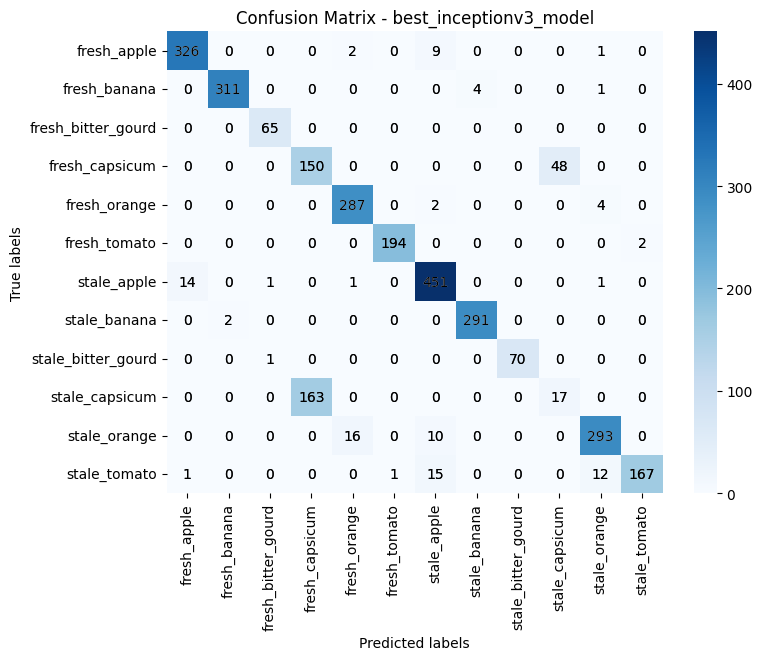

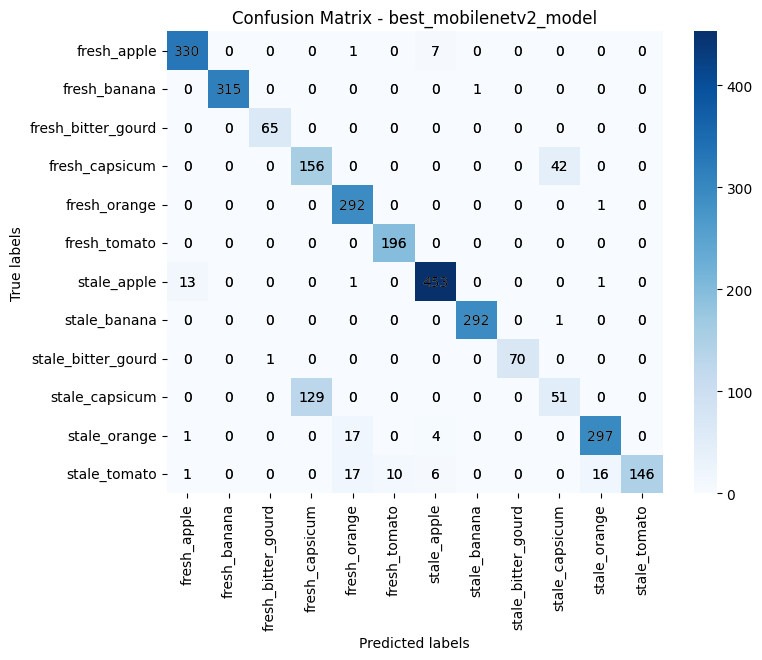

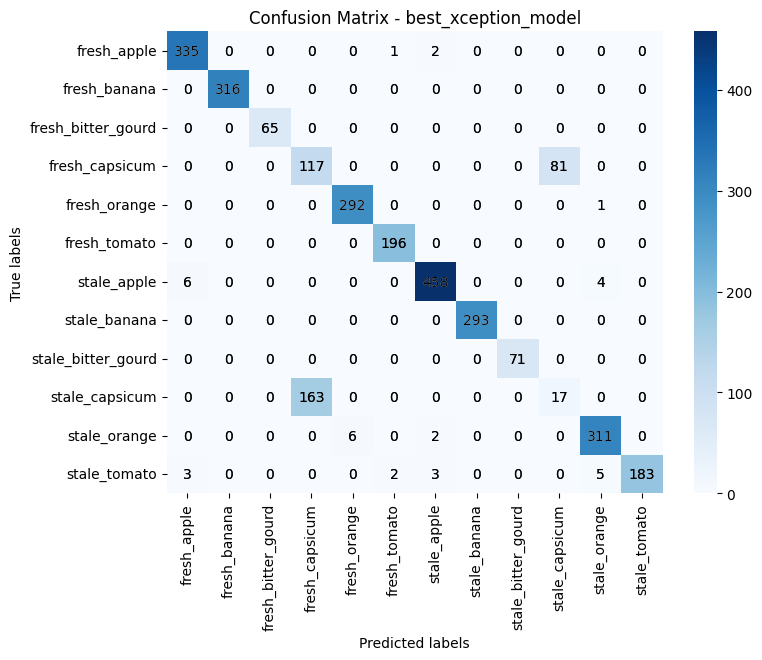

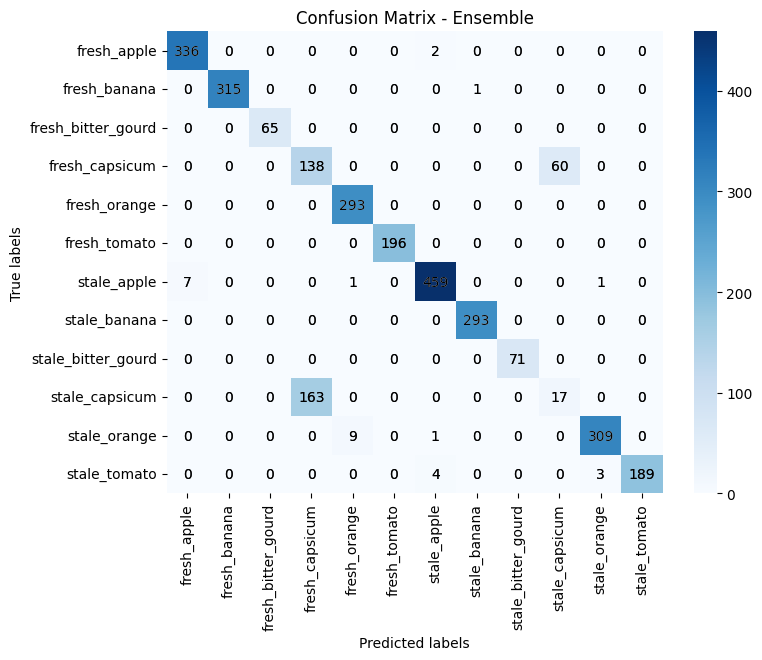

In [10]:

from sklearn.metrics import confusion_matrix

model_names = ['best_inceptionv3_model', 'best_mobilenetv2_model', 'best_xception_model']
for idx, predictions in enumerate(predictions_list):
    cm = confusion_matrix(val_generator.classes, np.argmax(predictions, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_names[idx]}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    for i in range(len(val_generator.class_indices)):
        for j in range(len(val_generator.class_indices)):
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='black')
    plt.show()

# Ensemble learning için confusion matrix oluştur
ensemble_cm = confusion_matrix(val_generator.classes, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
for i in range(len(val_generator.class_indices)):
    for j in range(len(val_generator.class_indices)):
        plt.text(j+0.5, i+0.5, ensemble_cm[i, j], ha='center', va='center', color='black')
plt.show()


1/1 [==============================] - 1s 1s/step


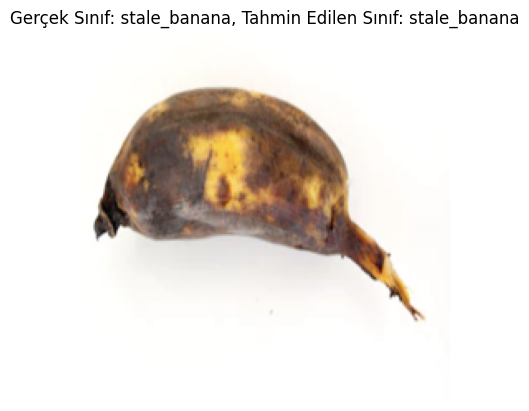

1/1 [==============================] - 0s 26ms/step


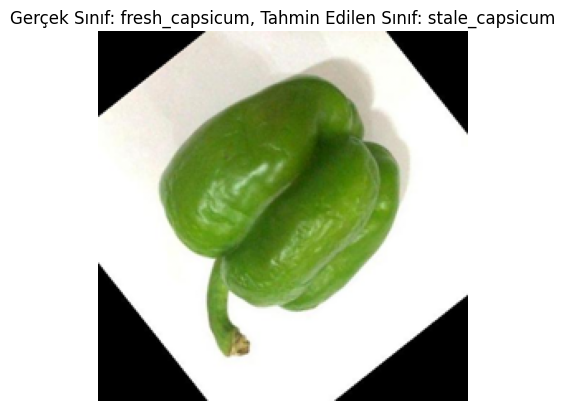

1/1 [==============================] - 0s 26ms/step


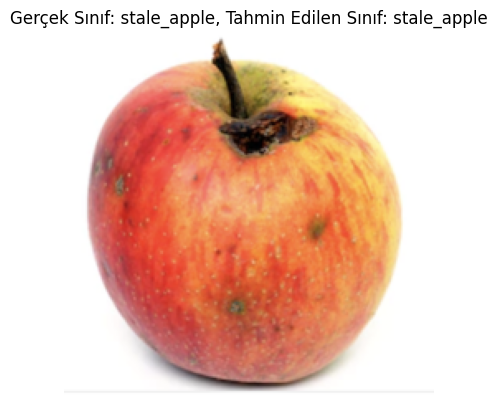

1/1 [==============================] - 0s 26ms/step


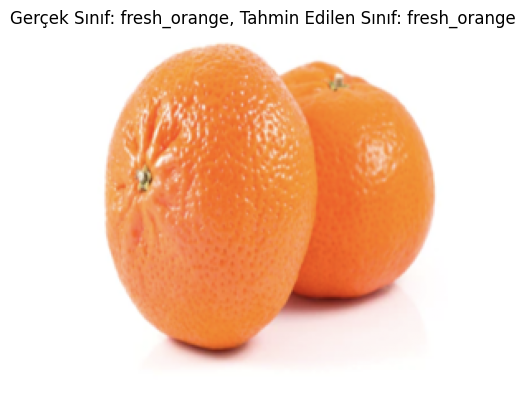

1/1 [==============================] - 0s 30ms/step


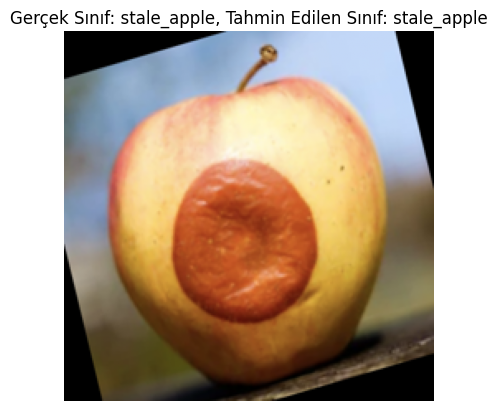

1/1 [==============================] - 0s 26ms/step


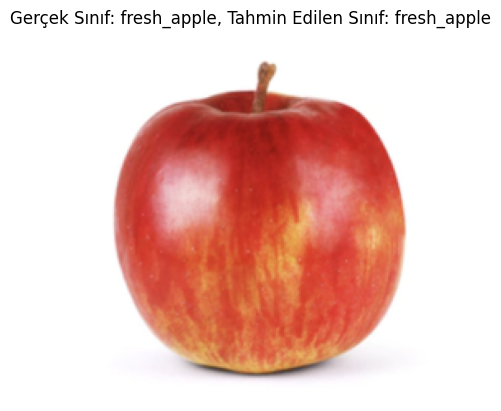

1/1 [==============================] - 0s 30ms/step


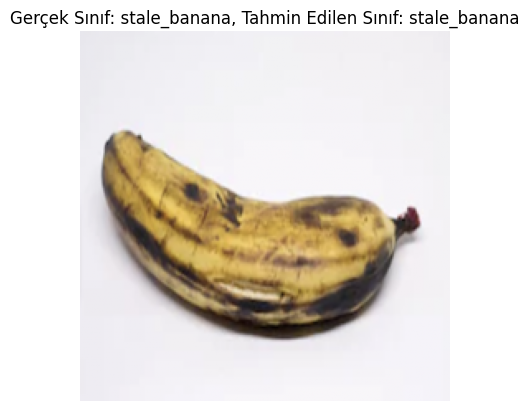

1/1 [==============================] - 0s 27ms/step


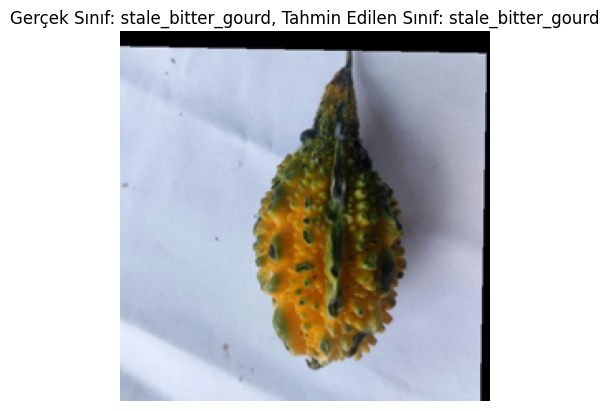

1/1 [==============================] - 0s 30ms/step


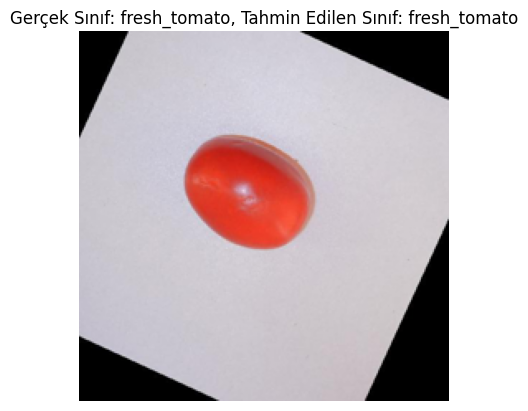

1/1 [==============================] - 0s 31ms/step


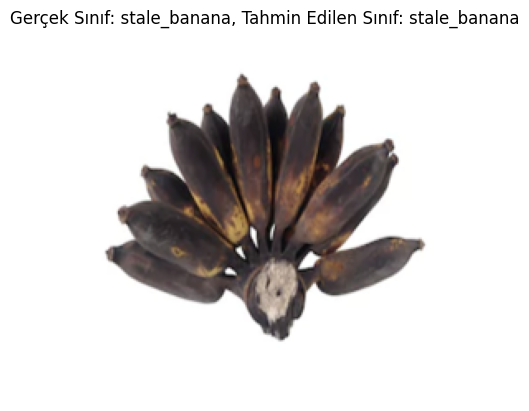

Toplam doğruluk: 0.9


In [11]:
import random
from PIL import Image

# Sınıf isimlerini al
class_names = list(fake_test_generator.class_indices.keys())

# Rastgele 10 görüntü seçme
random_image_paths = random.sample(fake_test_generator.filepaths, 10)

# Seçilen görüntülerin gerçek etiketleri ve tahminlerini tutacak listeler oluşturma
true_labels = []
predicted_labels = []

# Seçilen görüntüler için tahminler yapma
for image_path in random_image_paths:
    # Görüntüyü yükleme
    image = Image.open(image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Gerçek etiketi alarak isme dönüştürme
    true_label_index = fake_test_generator.classes[fake_test_generator.filepaths.index(image_path)]
    true_label = class_names[true_label_index]  # Gerçek etiketi isme dönüştürme

    # Gerçek ve tahmin edilen etiketleri listelere ekleme
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()

# Doğruluk hesaplama
accuracy = accuracy_score(true_labels, predicted_labels)
print("Toplam doğruluk:", accuracy)


In [12]:
# Sınıfları ve dosya sayılarını tutacak bir sözlük oluşturma
class_counts = {}

# Klasörleri gezerek her sınıfın dosya sayısını belirleme
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        file_count = len(os.listdir(class_path))
        class_counts[class_name] = file_count

# Toplam dosya sayısını ve sınıf adlarını görüntüleme
total_files = sum(class_counts.values())
print("Toplam Dosya Sayısı:", total_files)
print("\nSınıf Adları ve Dosya Sayıları:")
for class_name, file_count in class_counts.items():
    print(f"{class_name}: {file_count} dosya")

Toplam Dosya Sayısı: 14682

Sınıf Adları ve Dosya Sayıları:
fresh_apple: 1693 dosya
fresh_banana: 1581 dosya
fresh_bitter_gourd: 327 dosya
fresh_capsicum: 990 dosya
fresh_orange: 1466 dosya
fresh_tomato: 981 dosya
stale_apple: 2342 dosya
stale_banana: 1467 dosya
stale_bitter_gourd: 357 dosya
stale_capsicum: 901 dosya
stale_orange: 1595 dosya
stale_tomato: 982 dosya


In [14]:
best_mobilenetv2_model.summary()
best_inceptionv3_model.summary()
best_xception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 224)               286944    
                                                                 
 dropout_2 (Dropout)         (None, 224)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                2700      
                                                                 
Total params: 2,547,628
Trainable params: 289,644
Non-

1/1 [==============================] - 0s 29ms/step


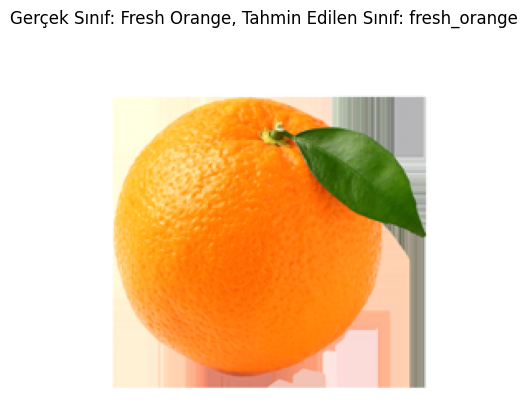

1/1 [==============================] - 0s 29ms/step


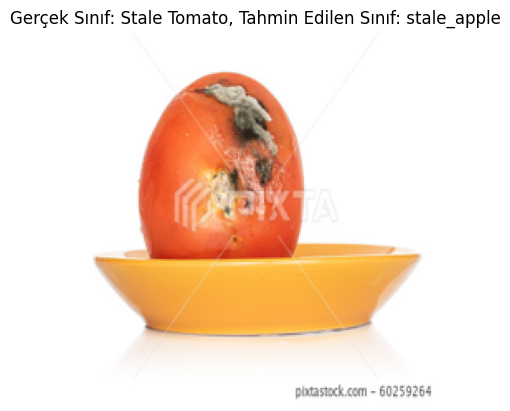

1/1 [==============================] - 0s 30ms/step


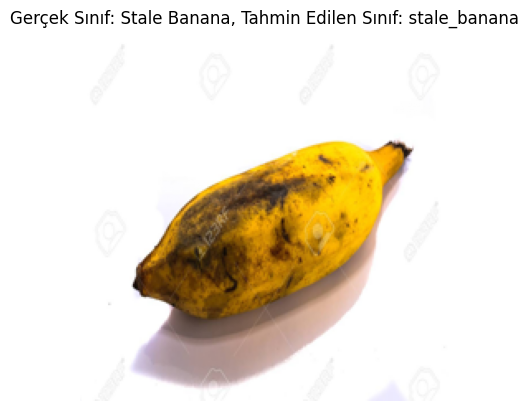

1/1 [==============================] - 0s 27ms/step


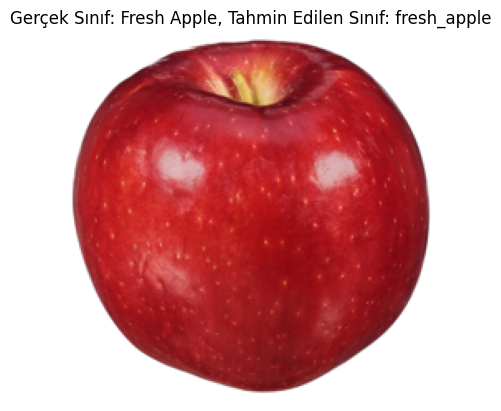

1/1 [==============================] - 0s 30ms/step


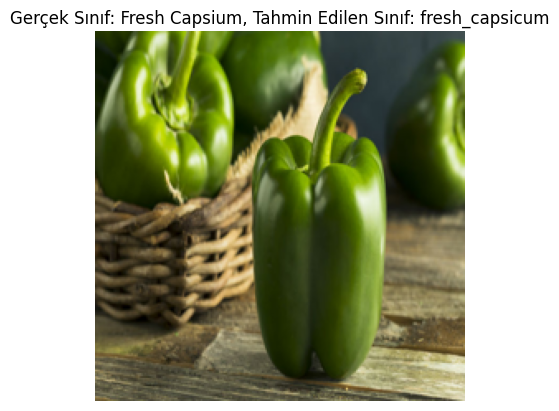

In [17]:
# Kullanıcı tarafından belirlenen iki özel görüntü
base_dir = 'C:/Users/Andac/Desktop/VERİSETLERİVE KODLAR'  # Dosya yolunu burada belirleyin

custom_image_paths = [
    os.path.join(base_dir, "orange.png"),
    os.path.join(base_dir, "tomato.jpg"),
    os.path.join(base_dir, "banana.jpg"),
    os.path.join(base_dir, "apple.jpeg"),
    os.path.join(base_dir, "Bell-pepper.jpg")
]
custom_true_labels = ["Fresh Orange", "Stale Tomato", "Stale Banana","Fresh Apple","Fresh Capsium"]  # Bu etiketleri gerçek sınıflarla güncelleyin

# Özel görüntüler için tahminler yapma
for custom_image_path, custom_true_label in zip(custom_image_paths, custom_true_labels):
    # Görüntü yolunun var olup olmadığını kontrol etme
    if not os.path.exists(custom_image_path):
        print(f"Dosya bulunamadı: {custom_image_path}")
        continue
    
    # Görüntüyü yükleme
    image = Image.open(custom_image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {custom_true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()